# TEST DASK CLUSTER

In [1]:
from dask.distributed import Client, SSHCluster
import sys
import dask
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import dask.dataframe as dd
import dask.array as da
import dask.bag as db
import matplotlib.pyplot as plt

from dask import delayed

##  DASK CLUSTER

In [2]:
cluster = SSHCluster(
    ["10.67.22.39", "10.67.22.74", "10.67.22.27", "10.67.22.91", "10.67.22.60"],
    connect_options   = {"known_hosts": "/root/.ssh/known_hosts"},
    worker_options    = {"nthreads": 2, "n_workers": 4},
    scheduler_options = {"dashboard_address": ":8787"}
)

2022-07-09 08:40:39,511 - distributed.deploy.ssh - INFO - 2022-07-09 08:40:39,510 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2022-07-09 08:40:39,566 - distributed.deploy.ssh - INFO - 2022-07-09 08:40:39,566 - distributed.scheduler - INFO - State start
2022-07-09 08:40:39,570 - distributed.deploy.ssh - INFO - 2022-07-09 08:40:39,569 - distributed.scheduler - INFO - Clear task state
2022-07-09 08:40:39,572 - distributed.deploy.ssh - INFO - 2022-07-09 08:40:39,570 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.39:35781
2022-07-09 08:40:41,066 - distributed.deploy.ssh - INFO - 2022-07-09 08:40:41,057 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.91:35523'
2022-07-09 08:40:41,069 - distributed.deploy.ssh - INFO - 2022-07-09 08:40:41,059 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.91:38951'
2022-07-09 08:40:41,071

In [3]:
client = Client(cluster)
client

<Client: 'tcp://10.67.22.39:35781' processes=12 threads=24, memory=46.62 GiB>

## Functions

In [4]:
def load(path):
    return np.load(path, allow_pickle=True)["a"]

@delayed    
def R_yz(theta_rot, phi_rot):
    return np.array([[np.cos(phi_rot) * np.cos(theta_rot), -np.sin(phi_rot) * np.cos(theta_rot), np.sin(theta_rot)], 
                     [np.sin(phi_rot), np.cos(phi_rot), 0], 
                     [-np.sin(theta_rot) * np.cos(phi_rot), np.sin(theta_rot) * np.sin(phi_rot), np.cos(theta_rot)]])

@delayed
def convert_pmt_ids(input_ids, conversion_ids):
    cd_ids  = np.array(conversion_ids["CdID"])
    pmt_ids = np.array(conversion_ids["PMTID"])
    mask    = np.isin(cd_ids, input_ids)
    return pmt_ids[mask]

@delayed
def find_pmt_coord(pmt_positions, data_pmt_id):
    return pmt_positions[
        np.isin(pmt_positions.PMTID, data_pmt_id)
        ].loc[:, ['x', 'y', 'z']].reset_index(drop=True).to_numpy()

## Load mapping data

In [5]:
data_folder       = "/root/data/data/real/train/data/"
pmt_pos_fname     = "PMTPos_CD_LPMT.csv"
pmt_id_conv_fname = "PMT_ID_conversion.csv"
train_data_fname  = "raw_data_train_4.npz"

# test multiple files
name_list = ["raw_data_train_4.npz", "raw_data_train_5.npz"]

In [6]:
pmt_positions     = pd.read_csv(pmt_pos_fname)
pmt_id_conversion = pd.read_csv(pmt_id_conv_fname)
conversion_ids    = pd.read_csv(pmt_id_conv_fname)

# data should not be loaded yet!
# data = dask.delayed(load)(data_folder+train_data_fname).compute()

## Distributed processing

In [7]:
N_max = 115

def rotate_single_file(fname):

    data_np = load(data_folder+train_data_fname) # dask.delayed(load)(data_folder+train_data_fname).compute()
    Nevents = 100 # data_np.shape[1]
    rotated = []

    for i in range(Nevents):
        # find non-zero-time hits
        data = da.from_array([data_np[:,i][j] for j in range(3)])
        nonzeros_inds = data[2] != 0.0
        data_pmt_id   = convert_pmt_ids(data[0][nonzeros_inds], conversion_ids)
        pmt_coord     = find_pmt_coord(pmt_positions, data_pmt_id)
        
        tot_charge = dask.delayed(sum)(data[1][nonzeros_inds])
        x_cc       = dask.delayed(sum)(pmt_coord[:,0] * data[1][nonzeros_inds]) / tot_charge
        y_cc       = dask.delayed(sum)(pmt_coord[:,1] * data[1][nonzeros_inds]) / tot_charge
        z_cc       = dask.delayed(sum)(pmt_coord[:,2] * data[1][nonzeros_inds]) / tot_charge
        
        theta_cc   = dask.delayed(da.arctan2)(
            dask.delayed(da.sqrt)((x_cc)**2+(y_cc)**2), z_cc
        )
        phi_cc     = dask.delayed(da.arctan2)(y_cc, x_cc) 
        
        theta_rot = -theta_cc + np.pi/2
        phi_rot   = -phi_cc
        
        # coord_new = np.matmul(R_yz(theta_rot, phi_rot), pmt_coord.T)
        coord_new = dask.delayed(da.matmul)(
            R_yz(theta_rot, phi_rot), pmt_coord.T
        )

        R = dask.delayed(da.sqrt)(dask.delayed(da.sum)(dask.delayed(da.power)(coord_new, 2), axis=0))

        charge_hitt = da.vstack([data[1], data[2]])
        charge_hitt = charge_hitt[:,nonzeros_inds]

        rotated.append(dask.delayed(da.vstack)([coord_new, R, charge_hitt]))
        del coord_new
        del charge_hitt
        del pmt_coord
    
    return rotated

def mapping_single_event(rotated_ev):
    ####################
    # rotated_ev must be computed
    ####################
    coord_new   = rotated_ev[:3]
    charge_hitt = rotated_ev[4:, ].T
    R           = rotated_ev[3, ].mean()

    z_levels, step = da.linspace(coord_new[2,].min(), coord_new[2,].max(), 124, retstep=True)
    z_levels       = z_levels.persist()
    image_mat      = da.zeros((230,124,2))

    for j, z in enumerate(z_levels):
        mask = (np.abs(coord_new[2,] - z) < step)         #(np.abs(pmt_pos.z - z) < delta)
        if(not da.any(mask)): continue
        masked = coord_new[:,mask]


        Rz = (R**2 - z**2)
        Neff = 0 if Rz < 0 else N_max * da.sqrt(Rz) / R
        #ix = np.zeros(np.sum(mask), dtype=np.int32)
        ix = da.around( Neff * (da.arctan2(masked[1,], masked[0,]) / np.pi) + (N_max / 2) ) + 57
        ix = ix.astype(np.int32)
        #ix = ix.compute()
        if(da.any(ix >= 230)):
            ix[ix >= 230] = ix[ix >= 230] - 230

        image_mat[ix, j,] = charge_hitt[mask, ]

                # if np.isnan(mat[ix, i+1]):
                #     mat[ix, i+1] = row.id
                # else:
                #     mat[ix, 123 if i else i] = row.id

    del rotated_ev
    return image_mat
    

### Retreive rotation results

In [8]:
rotated_one_file = rotate_single_file(train_data_fname) # qui dovremo fare un client.map quando mettiamo più files
#rotated_one_file.visualize()


# process multiple files
# rotate_multiple_files = client.map(rotate_single_file, name_list)

rotation_future  = client.map(dask.compute, rotated_one_file)

rotated          = client.gather(rotation_future)
persisted_rot    = [rotated[i][0].persist() for i in range(len(rotated))]

/root/anaconda3/envs/dask2/lib/python3.10/site-packages/distributed/worker.py:2823: UserWarning: Large object of size 1.33 MiB detected in task graph: 
  (Delayed('vstack-39282fdb-19f1-4573-91fd-032e932abe44'),)
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  warnings.warn(


#### Plot the rotated event

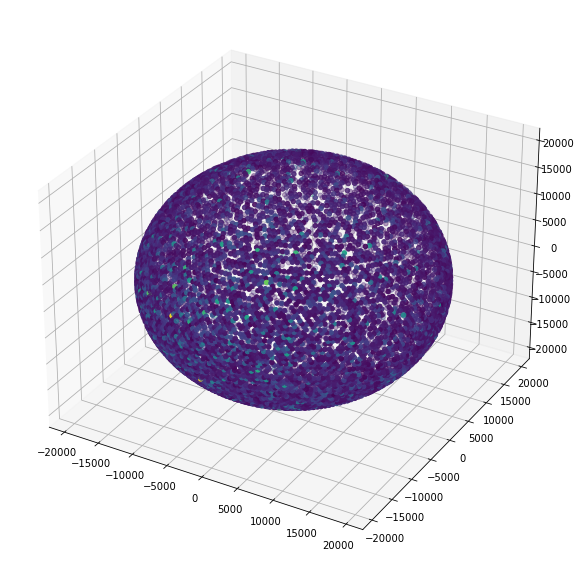

In [176]:
ev = 7
rot = persisted_rot[ev]

fig = plt.figure(figsize=(10,12))
axr = fig.add_subplot(111, projection='3d')

axr.scatter(
    xs = rot[1, :],
    ys = -rot[0, :],
    zs = rot[2, :],
    c  = rot[4, :]
    )

### Retreive mapping results

In [10]:
mapping_future   = client.map(mapping_single_event, persisted_rot)
mapped           = client.gather(mapping_future)
mapped

[dask.array<setitem, shape=(230, 124, 2), dtype=float64, chunksize=(230, 124, 2), chunktype=numpy.ndarray>,
 dask.array<setitem, shape=(230, 124, 2), dtype=float64, chunksize=(230, 124, 2), chunktype=numpy.ndarray>,
 dask.array<setitem, shape=(230, 124, 2), dtype=float64, chunksize=(230, 124, 2), chunktype=numpy.ndarray>,
 dask.array<setitem, shape=(230, 124, 2), dtype=float64, chunksize=(230, 124, 2), chunktype=numpy.ndarray>,
 dask.array<setitem, shape=(230, 124, 2), dtype=float64, chunksize=(230, 124, 2), chunktype=numpy.ndarray>]

In [43]:
mapped_future    = client.map(dask.compute, mapped)
mapped_computed  = client.gather(mapped_future)
mapped_images    = [mapped_computed[i][0] for i in range(len(mapped_computed))]
mapped_images[0].shape

(230, 124, 2)

## PLOT MAPPED EVENT

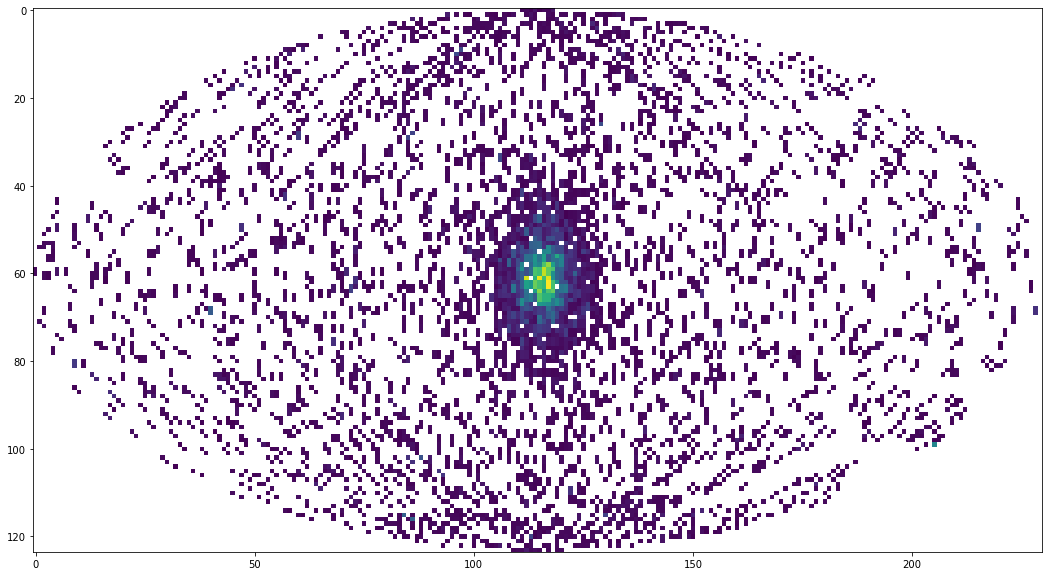

In [45]:
ev = 4

image = mapped_images[ev][:,:,0].T
image[image == 0] = np.NaN

fig, ax = plt.subplots(1, figsize=(20,10))
ax.imshow(image)
plt.show()

# ***Stop Cluster (!)***

In [4]:
# try this and check dashboard
client.shutdown()

In [1]:
# if dashboard is still up then run this and should go down
client.run_on_scheduler(lambda dask_scheduler=None: 
    dask_scheduler.close() & sys.exit(0))

# an error should occur but its fine 

NameError: name 'client' is not defined

## optimizing mapping

In [ ]:
def mapping_single_event(rotated_ev):
    ####################
    # rotated_ev must be computed
    ####################
    coord_new   = rotated_ev[:3]
    charge_hitt = rotated_ev[4:, ].T
    R           = rotated_ev[3, ].mean()
    del rotated_ev

    z_levels, step = np.linspace(coord_new[2,].min(), coord_new[2,].max(), 124, retstep=True)
    #z_levels       = z_levels.persist()
    image_mat      = np.zeros((230,124,2))

    #masks = 

    for j, z in enumerate(z_levels):
        mask = (np.abs(coord_new[2,] - z) < step)         #(np.abs(pmt_pos.z - z) < delta)
        if(not np.any(mask)): continue
        masked = coord_new[:,mask]


        Rz = (R**2 - z**2)
        Neff = 0 if Rz < 0 else N_max * np.sqrt(Rz) / R
        #ix = np.zeros(np.sum(mask), dtype=np.int32)
        ix = np.around( Neff * (np.arctan2(masked[1,], masked[0,]) / np.pi) + (N_max / 2) ) + 57
        ix = ix.astype(np.int32)
        #ix = ix.compute()
        if(np.any(ix >= 230)):
            ix[ix >= 230] = ix[ix >= 230] - 230

        image_mat[ix, j,] = charge_hitt[mask, ]

        del ix
        del masked
        del mask
                

    del z_levels
    del coord_new
    del charge_hitt
    
    return image_mat

In [151]:
from time import time

In [153]:
persisted_rot = [ev.compute() for ev in persisted_rot]

In [165]:
start = time()
N_max = 115
results = []
for ev in persisted_rot:
    sample = ev
    coord_new   = sample[:3]
    charge_hitt = sample[4:, ].T
    R           = sample[3, ].mean()
    del sample

    z_levels, step = np.linspace(coord_new[2,].min(), coord_new[2,].max(), 124, retstep=True)
    #z_levels       = z_levels.persist()
    image_mat      = np.zeros((124, 230,2))
    masks = (np.abs(coord_new[2,].reshape((1, -1)) - z_levels.reshape((-1,1))) < step/2) 
    Rzs = (R**2 - z_levels**2)
    Neffs = np.zeros(124)
    Neffs[Rzs >=0 ] = N_max * np.sqrt(Rzs[Rzs>=0]) / R
    i=0
    for mask, Neff in zip(masks, Neffs):
        ix = np.around( Neff * (np.arctan2(coord_new[1,mask], coord_new[0,mask]) / np.pi) + (N_max / 2) ) +57
        ix = ix.astype(np.int32)
        if(np.any(ix >= 230)):
            ix[ix >= 230] = ix[ix >= 230] - 230
        #arr_ix = np.full(230, False)
        #arr_ix[ix] = True
        image_mat[i, ix,] = charge_hitt[mask,]
        i += 1
    results.append(image_mat)

result = np.stack(results)
stop=time()

print('Execution time:', stop-start)

Execution time: 2.1572999954223633


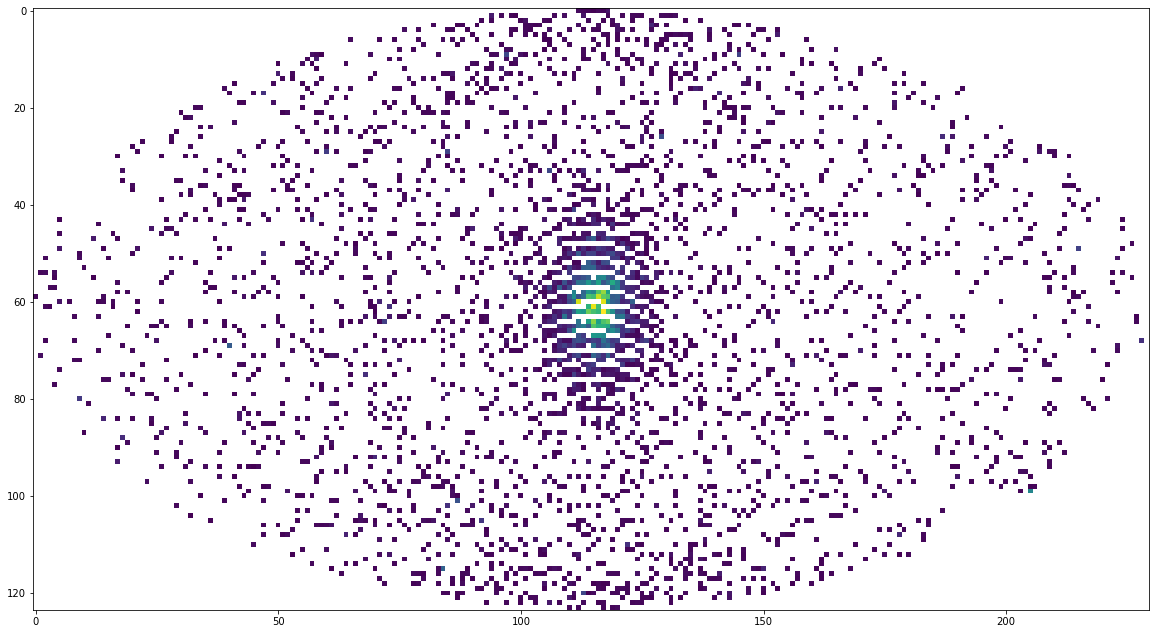

In [178]:
ev = 4
image = result[ev][:,:,0]
image[image == 0] = np.nan
fig, ax = plt.subplots(1, figsize=(20, 30))
plt.imshow(image)

In [82]:
n.compute()

4315

In [24]:
masks = (np.abs(coord_new[2,].reshape((1, -1)) - z_levels.reshape((-1,1))) < step/2) 

In [42]:
masks=masks.compute()

In [80]:
masks.shape

(124, 4315)

In [12]:
masks.sum()

4315

In [100]:
Rs = np.ma.array(np.resize(R, (124, len(R))), mask=masks).mean(axis=1)

In [102]:
Rs

masked_array(data=[19433.89445032, 19433.909454496174, 19433.924934024577,
                   19433.894154906193, 19433.89422890174,
                   19433.894105501793, 19433.894006642564,
                   19433.89417954772, 19433.89425358735,
                   19433.893907519887, 19433.894080853035,
                   19433.894056085926, 19433.894130172685,
                   19433.894130198103, 19433.89415489926,
                   19433.894179545332, 19433.893857840543,
                   19433.894080813086, 19433.89413017859,
                   19433.893808199748, 19433.893932245795,
                   19433.89385781381, 19433.894031361873,
                   19433.89388262565, 19433.89390735639,
                   19433.894006560626, 19433.894056088004,
                   19433.893932185856, 19433.894006450897,
                   19433.893833094862, 19433.894204243872,
                   19433.89390744231, 19433.89408080536,
                   19433.893956966098, 19433.89408

In [103]:
Rzs = (Rs**2 - z_levels**2)
Neff = np.zeros(124)
Neff[Rzs >=0 ] = N_max * np.sqrt(Rzs[Rzs>=0]) / Rs[Rzs>=0]

In [28]:
coord_new = coord_new.compute()

AttributeError: 'numpy.ndarray' object has no attribute 'compute'

In [108]:

def mask_ix(coord_new, masks, Neffs):
    mask_ix = []
    i=0
    for mask, Neff in zip(masks, Neffs):
        ix = np.around( Neff * (np.arctan2(coord_new[0,mask], coord_new[1,mask]) / np.pi) + (N_max / 2) )
        ix = ix.astype(np.int32)
        if(np.any(ix >= 230)):
            ix[ix >= 230] = ix[ix >= 230] - 230
        #arr_ix = np.full(230, False)
        #arr_ix[ix] = True
        image_mat[i, ix,] = charge_hitt[mask,]
        
    
    return(image_mat)

In [109]:
image_mat = mask_ix(coord_new, masks, Neff)
image_mat

array([[[0.3126787741333085, 1163.282822857143],
        [1.4596682533053644, 261.6835571428572],
        [0.9217435488506069, 252.15312857142857],
        ...,
        [1.0979751843474501, 403.58284285714285],
        [1.4381667516301162, 330.8548428571429],
        [0.8090809821091756, 1089.7555371428573]],

       [[0, 0],
        [0, 0],
        [0, 0],
        ...,
        [0, 0],
        [0, 0],
        [0, 0]],

       [[0, 0],
        [0, 0],
        [0, 0],
        ...,
        [0, 0],
        [0, 0],
        [0, 0]],

       ...,

       [[0, 0],
        [0, 0],
        [0, 0],
        ...,
        [0, 0],
        [0, 0],
        [0, 0]],

       [[0, 0],
        [0, 0],
        [0, 0],
        ...,
        [0, 0],
        [0, 0],
        [0, 0]],

       [[0, 0],
        [0, 0],
        [0, 0],
        ...,
        [0, 0],
        [0, 0],
        [0, 0]]], dtype=object)

In [70]:
ixs[62]

array([228,   5, 206,  24,  37,  42,  53,  61, 162, 159,  69,  76,  77,
       147,  79,  81, 141, 142, 143,  94,  96, 131, 132, 133, 104, 108,
       110, 111, 112, 113, 116, 118, 120, 123, 126], dtype=int32)

In [41]:
n=0
for ix in ixs:
    n += len(ix)
n

4315

In [56]:
image_mat[ixs, 0]

/tmp/ipykernel_64802/1682263481.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  image_mat[ixs, 0]


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [74]:
image_mat[ixs.T, 0] = charge_hitt[np.where(masks.compute())[1],0]

ValueError: shape mismatch: value array of shape (8630,) could not be broadcast to indexing result of shape (7599,)

In [71]:
np.where(masks.compute())[1]

array([  0,   0,   0, ..., 123, 123, 123])

In [59]:
charge_hitt = charge_hitt.compute()

In [73]:
len(charge_hitt[np.where(masks.compute())[1],0])

8630

In [179]:
client.shutdown()